# Overview
The notebook shows how to extract the segmentation map for the ships, augment the images and train a simple DNN model to detect them. A few additional tweaks like balancing the ship-count out a little better have been done.

## Importing Packages

In [1]:
import os
import numpy as np 
import pandas as pd 
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
import gc; gc.enable() 
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_opening, disk, label

In [2]:
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
model_dir = '/kaggle/working/Unet_model'

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [3]:
BATCH_SIZE = 64
EDGE_CROP = 16
NB_EPOCHS = 99
VALID_IMG_COUNT = 900
MAX_TRAIN_STEPS = 9
IMG_SCALING = (3, 3)
AUGMENT_BRIGHTNESS = False

# Creating Our Masks
We decode and encode our pictures using the following functions.  
masks_as_images is used to gather all masks of ships belonging to one image in one image.  
Resource: https://www.kaggle.com/code/inversion/run-length-decoding-quick-start

In [4]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Gather masks of ships in the same picture into one picture.
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

# Loading the Data

In [5]:
masks = pd.read_csv(os.path.join('../input/',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Make sure encode/decode works
Given the process
$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$
We want to check if/that
$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $
We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.



Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


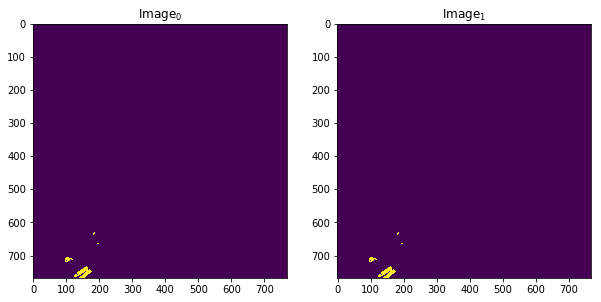

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

,ImageId,ships,has_ship,file_size_kb
93534,7c5de24e9.jpg,0,0.0,216.738281
21305,1c505fa71.jpg,0,0.0,90.270508
32138,2aad8501f.jpg,0,0.0,150.990234
102496,884f9d5fa.jpg,0,0.0,74.988281
95362,7ecb4aff2.jpg,0,0.0,123.983398


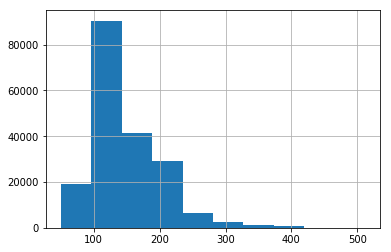

In [7]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

12788 masks


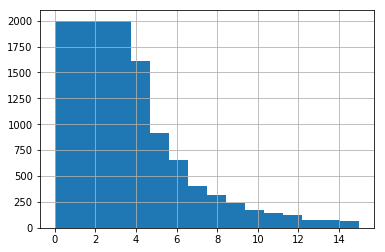

In [8]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

# Creating our Train/Validation set

In [9]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images.
* Load the image.
* Generate its mask.
* Check if there is img scaling so that we change our step size.
* Yield two stacks containing the images and masks when we reach the batch size.

In [10]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [11]:
train_gen = make_image_gen(train_df)
print(train_gen)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

<generator object make_image_gen at 0x7f3782a3cb48>
x (64, 256, 256, 3) 0.0 1.0
y (64, 256, 256, 1) 0 1


# Create a Montage of Random Sample to Check their Masks

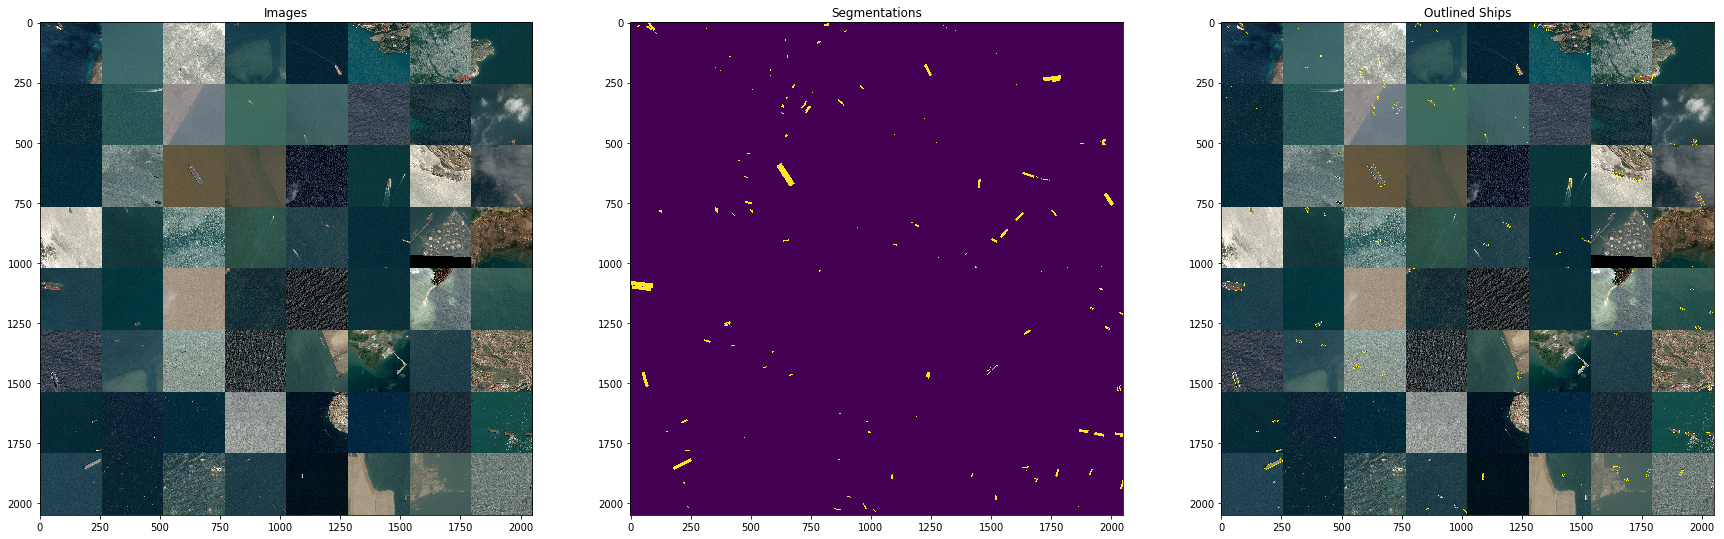

In [12]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Generate the Validation Set
Validation entries count is prone to changing but increasing it any further might crash the kernel.

In [13]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


In [15]:
gc.collect()

0

# Image Augmentation
Resource: https://www.kaggle.com/code/kmader/baseline-u-net-model-part-1?scriptVersionId=6617956

In [16]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Using TensorFlow backend.


# Build a Model
Here we use a slight deviation on the U-Net standard.  
We use less filters to lower the number of parameters.


In [17]:
import tensorflow as tf

input_image = tf.keras.Input(train_x.shape[1:])

c1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(input_image)
c2 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(c1)

m1 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(m1)
c4 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(c3)

m2 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(m2)
c6 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c5)

m3 = tf.keras.layers.MaxPooling2D((2, 2))(c6)

c7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(m3)
c8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c7)

m4 = tf.keras.layers.MaxPooling2D((2, 2))(c8)

c9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(m4)
c10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(c9)

t1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2) , padding='same')(c10)
t1 = tf.keras.layers.concatenate([t1, c8], axis=3)

c11 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(t1)
c12 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c11)

t2 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c12)
t2 = tf.keras.layers.concatenate([t2, c6], axis=3)

c13 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(t2)
c14 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c13)

t3 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c14)
t3 = tf.keras.layers.concatenate([t3, c4], axis=3)

c15 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(t3)
c16 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(c15)

t4 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c16)
t4 = tf.keras.layers.concatenate([t4, c2], axis=3)

c17 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(t4)
c18 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(c17)

c19 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c18)

model = tf.keras.Model(inputs=[input_image], outputs=[c19])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

# Implementing IoU for Measuring Loss
We use the IoU as a metric to measure our train/validation loss. This is done by simply returning the - IoU.

In [18]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

# Setting Up Auxiliary Functions
* We save our weights using ModelCheckpoint since the kernel used to crash in earlier runs.


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
    
weight_path="{}_weights.best.hdf5".format(model_dir)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33, 
                                   patience=1, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      verbose = 2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
def fit():
    model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=NB_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

In [ ]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [ ]:
model.load_weights(weight_path)
model.save('Unet_model.h5')

In [ ]:
pred_y = model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Finalizing the Model
We add an AvgPool2D layer to downscale the image before entering the model (768 -> 256)  
Then we use an UpSampling2D layer to upscale the image back to its original size (256 -> 768)

In [ ]:
if IMG_SCALING is not None:
    fullres_model = tf.keras.Sequential()
    fullres_model.add(tf.keras.layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(model)
    fullres_model.add(tf.keras.layers.UpSampling2D(IMG_SCALING))

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

In [ ]:
print(masks.head())

# Validation Data Prediction

In [ ]:
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(20, 3, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), c_img_name in zip(m_axs, samples.ImageId.values):
    c_path = os.path.join(train_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
    ax3.imshow(masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax3.set_title('Ground Truth')
fig.savefig('test_predictions.png')

# Test Data Prediction

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 200))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')